In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import timeit
import datetime
import time
import pprint
import itertools
import pickle
import sklearn
import dask
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
import fastparquet
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import h5py
import dask
import dask.dataframe as dd
import dask.array as da
# Percentiles
from scipy.stats import percentileofscore
from IPython.display import display

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
inv_pairs = fastparquet.ParquetFile("DataStore/2018-07-P2/inv_move_pat_pairs_0714.parq").to_pandas()
print(len(inv_pairs))
inv_pairs = inv_pairs.loc[inv_pairs["sim_docvecs"].notnull() & inv_pairs["sim_ldavecs"].notnull()]
print(len(inv_pairs))

694573
571068


In [3]:
ip = pd.read_pickle("DataStore/2018-07/inv_move_pats_0712.pkl")
ip = dict(zip(ip["patent"], ip["inv_asg_rank"]))
inv_pairs["tp_asg_rank"] = inv_pairs["tp"].map(ip)

# Bins
import math

def sim_bin(x, a):
    try:
        return round(round(x / a) * a, -int(math.floor(math.log10(a))))
    except:
        return np.nan
    
inv_pairs["bin_sim_ldavecs"] = inv_pairs["sim_ldavecs"].apply(lambda x: sim_bin(x, 0.1))
inv_pairs["bin_sim_docvecs"] = inv_pairs["sim_docvecs"].apply(lambda x: sim_bin(x, 0.1))

In [4]:
inv_pairs["bin_sim_docvecs"].value_counts()

 0.2    132659
 0.3    125336
 0.1     94542
 0.4     84839
 0.5     43424
 0.0     41164
 0.6     19237
-0.1     11073
 0.7      9388
 0.8      5200
-0.2      2251
 0.9      1122
-0.3       524
-0.4       165
 1.0       111
-0.5        24
-0.6         8
-0.7         1
Name: bin_sim_docvecs, dtype: int64

In [4]:
# Exclude same firm citations at inventor's second location
print(len(inv_pairs))
i2 = inv_pairs.loc[~((inv_pairs["tp_asg_rank"] == 1) & (inv_pairs["asg_match"] == True))]
print(len(i2))
# # Get rid of outlying docvecs
i2 = i2.loc[(i2["bin_sim_docvecs"] >= -0.2) & (i2["bin_sim_docvecs"] <= 0.9)]
# Put together highest in bin
i2.loc[i2["bin_sim_docvecs"] >= 0.8, "bin_sim_docvecs"] = 0.8
print(len(i2))
# Change label
i2["firm_change"] = i2["asg_match"].apply(lambda x: "Before" if x is True else "After")

571068
362673
362194


In [9]:
# Example of pairs of non-citations
i2.loc[(i2["op_cites_tp"] == False) & (i2["sim_docvecs"] >= 0.8) & (i2["asg_match"] == False)].sample(5)

,op,tp,inventor_id,tp_asg,op_asg,asg_match,op_cites_tp,sim_ldavecs,sim_docvecs,tp_asg_rank,bin_sim_ldavecs,bin_sim_docvecs,firm_change
index,,,,,,,,,,,,,
355368,5374718,5216143,4950613-3,f967d011d2efe23d69b86e08dbc78a9f,40966594e6f2e34063a537b443e720dc,False,False,0.432302,0.822461,1,0.4,0.8,After
486878,6877544,6125904,6116301-2,e34f083218df0cf0282864b97d8ada95,e9f06d41753f721b5abe9ca931ae6531,False,False,0.999514,0.900420,0,1.0,0.8,After
469618,5903469,5828580,5828580-1,f642c4b175ca0ac36c5158934d9e359e,5a4369f62c4d0733c75dbe61b503fe21,False,False,0.907267,0.846764,0,0.9,0.8,After
391792,6061829,5829057,5308121-1,0e71c3a3511fb32935507171acc03f0d,d5d432f850a3d3865c6774297bbc1b17,False,False,0.993134,0.847094,0,1.0,0.8,After
653948,7436311,7034691,7034691-4,a6e695ae9a8c76d2d3ed9f521c233488,adf89331c8ad62a478e2967d610f05d7,False,False,0.999207,0.843312,0,1.0,0.8,After


### 1. Tables

In [12]:
i_dict = {'firm_change_Before_count': 'Before Firm Change, $N$', 
          'firm_change_Before_direct_cites': 'Before Firm Change, Prop Cites',
       'firm_change_After_count': 'After Firm Change, $N$',
          'firm_change_After_direct_cites': 'After Firm Change, Prop Cites',
         "Diff, $p$-value": "Diff, $p$-value"}

In [24]:
tab = {}
for dm in ["bin_sim_ldavecs", "bin_sim_docvecs"]:
    summ = pd.DataFrame()
    c = "firm_change"
    c_vals = ["Before", "After"]
    
    for m in c_vals:
        m2 = i2.loc[i2[c] == m]
        summ["{0}_{1}_count".format(c, str(m))] = m2.groupby([dm]).size().astype(str)
        summ["{0}_{1}_direct_cites".format(c, str(m))] = np.round(m2[[dm, "op_cites_tp"]].groupby(dm).mean(),3)
    
    summ = summ.rename(columns=i_dict)
    tab[dm] = summ.T
tab_no_p = tab

In [25]:
for k,v in tab_no_p.items():
    print(k)
    display(v)
    print(v.to_latex())

bin_sim_ldavecs


bin_sim_ldavecs,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
"Before Firm Change, $N$",16504,26692,27155,27020,27804,26407,24503,22366,20941,18917,8438
"Before Firm Change, Prop Cites",0.077,0.084,0.112,0.106,0.108,0.126,0.129,0.134,0.151,0.132,0.106
"After Firm Change, $N$",9597,13959,13721,12913,12768,12489,11944,10842,9106,6305,1803
"After Firm Change, Prop Cites",0.009,0.018,0.029,0.04,0.054,0.064,0.075,0.091,0.095,0.102,0.159


\begin{tabular}{llllllllllll}
\toprule
bin\_sim\_ldavecs &    0.0 &    0.1 &    0.2 &    0.3 &    0.4 &    0.5 &    0.6 &    0.7 &    0.8 &    0.9 &    1.0 \\
\midrule
Before Firm Change, \$N\$        &  16504 &  26692 &  27155 &  27020 &  27804 &  26407 &  24503 &  22366 &  20941 &  18917 &   8438 \\
Before Firm Change, Prop Cites &  0.077 &  0.084 &  0.112 &  0.106 &  0.108 &  0.126 &  0.129 &  0.134 &  0.151 &  0.132 &  0.106 \\
After Firm Change, \$N\$         &   9597 &  13959 &  13721 &  12913 &  12768 &  12489 &  11944 &  10842 &   9106 &   6305 &   1803 \\
After Firm Change, Prop Cites  &  0.009 &  0.018 &  0.029 &   0.04 &  0.054 &  0.064 &  0.075 &  0.091 &  0.095 &  0.102 &  0.159 \\
\bottomrule
\end{tabular}

bin_sim_docvecs


bin_sim_docvecs,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8
"Before Firm Change, $N$",671,3898,15868,38162,55625,54663,37899,20148,10389,5871,3553
"Before Firm Change, Prop Cites",0.042,0.052,0.059,0.068,0.081,0.104,0.137,0.196,0.263,0.283,0.278
"After Firm Change, $N$",624,2984,9869,20627,26876,24676,16732,8283,3008,1056,712
"After Firm Change, Prop Cites",0.006,0.011,0.011,0.02,0.037,0.06,0.089,0.115,0.164,0.231,0.296


\begin{tabular}{llllllllllll}
\toprule
bin\_sim\_docvecs &   -0.2 &   -0.1 &    0.0 &    0.1 &    0.2 &    0.3 &    0.4 &    0.5 &    0.6 &    0.7 &    0.8 \\
\midrule
Before Firm Change, \$N\$        &    671 &   3898 &  15868 &  38162 &  55625 &  54663 &  37899 &  20148 &  10389 &   5871 &   3553 \\
Before Firm Change, Prop Cites &  0.042 &  0.052 &  0.059 &  0.068 &  0.081 &  0.104 &  0.137 &  0.196 &  0.263 &  0.283 &  0.278 \\
After Firm Change, \$N\$         &    624 &   2984 &   9869 &  20627 &  26876 &  24676 &  16732 &   8283 &   3008 &   1056 &    712 \\
After Firm Change, Prop Cites  &  0.006 &  0.011 &  0.011 &   0.02 &  0.037 &   0.06 &  0.089 &  0.115 &  0.164 &  0.231 &  0.296 \\
\bottomrule
\end{tabular}



In [26]:
tab = {}
for dm in ["bin_sim_ldavecs", "bin_sim_docvecs"]:
    summ = pd.DataFrame()
    c = "firm_change"
    c_vals = ["Before", "After"]
    mg = i2[[dm, c, "op_cites_tp"]].groupby(dm)
    pval = [sp.stats.ttest_ind(g.loc[(g[c] == c_vals[0]), "op_cites_tp"],\
                              g.loc[(g[c] == c_vals[1]), "op_cites_tp"])[1]\
           for n,g in mg]
    
    for m in c_vals:
        m2 = i2.loc[i2[c] == m]
        summ["{0}_{1}_count".format(c, str(m))] = m2.groupby([dm]).size().astype(str)
        summ["{0}_{1}_direct_cites".format(c, str(m))] = np.round(m2[[dm, "op_cites_tp"]].groupby(dm).mean(),3)
    
    summ = summ.rename(columns=i_dict)
    summ["Diff, $p$-value"] = np.round(pval,3)
    tab[dm] = summ.T
tab_p = tab

In [27]:
for k,v in tab_p.items():
    print(k)
    display(v)
    print(v.to_latex())

bin_sim_ldavecs


bin_sim_ldavecs,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
"Before Firm Change, $N$",16504,26692,27155,27020,27804,26407,24503,22366,20941,18917,8438
"Before Firm Change, Prop Cites",0.077,0.084,0.112,0.106,0.108,0.126,0.129,0.134,0.151,0.132,0.106
"After Firm Change, $N$",9597,13959,13721,12913,12768,12489,11944,10842,9106,6305,1803
"After Firm Change, Prop Cites",0.009,0.018,0.029,0.04,0.054,0.064,0.075,0.091,0.095,0.102,0.159
"Diff, $p$-value",0,0,0,0,0,0,0,0,0,0,0


\begin{tabular}{llllllllllll}
\toprule
bin\_sim\_ldavecs &    0.0 &    0.1 &    0.2 &    0.3 &    0.4 &    0.5 &    0.6 &    0.7 &    0.8 &    0.9 &    1.0 \\
\midrule
Before Firm Change, \$N\$        &  16504 &  26692 &  27155 &  27020 &  27804 &  26407 &  24503 &  22366 &  20941 &  18917 &   8438 \\
Before Firm Change, Prop Cites &  0.077 &  0.084 &  0.112 &  0.106 &  0.108 &  0.126 &  0.129 &  0.134 &  0.151 &  0.132 &  0.106 \\
After Firm Change, \$N\$         &   9597 &  13959 &  13721 &  12913 &  12768 &  12489 &  11944 &  10842 &   9106 &   6305 &   1803 \\
After Firm Change, Prop Cites  &  0.009 &  0.018 &  0.029 &   0.04 &  0.054 &  0.064 &  0.075 &  0.091 &  0.095 &  0.102 &  0.159 \\
Diff, \$p\$-value                &      0 &      0 &      0 &      0 &      0 &      0 &      0 &      0 &      0 &      0 &      0 \\
\bottomrule
\end{tabular}

bin_sim_docvecs


bin_sim_docvecs,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8
"Before Firm Change, $N$",671,3898,15868,38162,55625,54663,37899,20148,10389,5871,3553
"Before Firm Change, Prop Cites",0.042,0.052,0.059,0.068,0.081,0.104,0.137,0.196,0.263,0.283,0.278
"After Firm Change, $N$",624,2984,9869,20627,26876,24676,16732,8283,3008,1056,712
"After Firm Change, Prop Cites",0.006,0.011,0.011,0.02,0.037,0.06,0.089,0.115,0.164,0.231,0.296
"Diff, $p$-value",0,0,0,0,0,0,0,0,0,0.001,0.322


\begin{tabular}{llllllllllll}
\toprule
bin\_sim\_docvecs &   -0.2 &   -0.1 &    0.0 &    0.1 &    0.2 &    0.3 &    0.4 &    0.5 &    0.6 &    0.7 &    0.8 \\
\midrule
Before Firm Change, \$N\$        &    671 &   3898 &  15868 &  38162 &  55625 &  54663 &  37899 &  20148 &  10389 &   5871 &   3553 \\
Before Firm Change, Prop Cites &  0.042 &  0.052 &  0.059 &  0.068 &  0.081 &  0.104 &  0.137 &  0.196 &  0.263 &  0.283 &  0.278 \\
After Firm Change, \$N\$         &    624 &   2984 &   9869 &  20627 &  26876 &  24676 &  16732 &   8283 &   3008 &   1056 &    712 \\
After Firm Change, Prop Cites  &  0.006 &  0.011 &  0.011 &   0.02 &  0.037 &   0.06 &  0.089 &  0.115 &  0.164 &  0.231 &  0.296 \\
Diff, \$p\$-value                &      0 &      0 &      0 &      0 &      0 &      0 &      0 &      0 &      0 &  0.001 &  0.322 \\
\bottomrule
\end{tabular}



#### 1.1 What's size of problem?
- What if After Firm Change cited at same rate as Before Firm Change?
- Take difference of sum of citations adjusted with actual sum of citations

In [17]:
v = tab_no_p["bin_sim_docvecs"]
num_actual_cites = v.loc["After Firm Change, $N$"].astype(float)*v.loc["After Firm Change, Prop Cites"]
# prop_before_cites = v.loc["Before Firm Change, Prop Cites"]
num_adj_cites = v.loc["After Firm Change, $N$"].astype(float)*v.loc["Before Firm Change, Prop Cites"]
sum_n = sum(num_actual_cites)
sum_n_a = sum(num_adj_cites)

In [18]:
print(sum_n, sum_n_a)

6422.428 12111.799


In [19]:
total_missing = np.round(sum_n_a-sum_n)
total_cites = i2["op_cites_tp"].sum()

# Total missing as a proportion of total citations in the sample
print(total_missing/total_cites)

# Total missing as a proportion of total actual citations in the sample
print(total_missing/sum_n)

0.16311141693904466
0.8858020673801248


### 2. Plots

In [20]:
%matplotlib inline
c_dict = pickle.load(open("DataStore/2018-06/col_names_dict.pkl", "rb"))

sns.set(font_scale=1.4)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 20})
savepath = "DataStore/2018-07-P2/ResultsGraphs/SNC/"
def p1(x, y, hue, data, bars, order, ax): 
    g = sns.pointplot(x = x, y = y, hue = hue, 
                data = data, ci = bars, markers = ".", 
                order = order, dodge = True, errwidth = 1,
                palette = sns.color_palette("Greys_r", 3),
                n_boot = 100,      
                  ax = ax)
    sns.despine()
    return g

    
def p2(x, y, data, order, ax, conf_int = None):
    g = sns.pointplot(x=x, y=y, data = data, ci = conf_int, join = True,
                 order = order, markers = ".", color="grey", ax = ax)
    sns.despine()
    return g

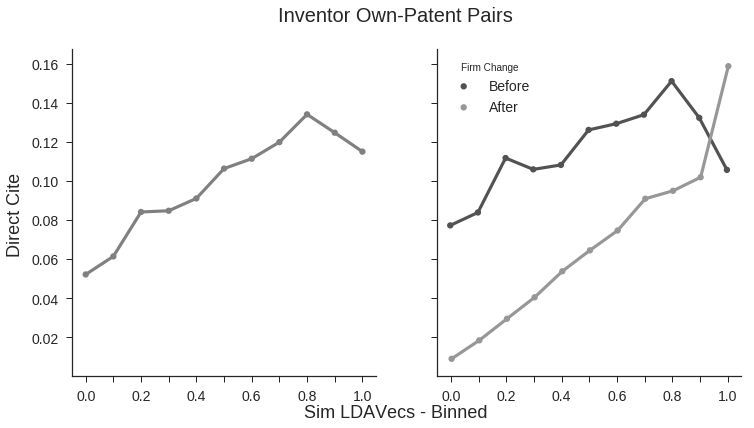

In [21]:
%matplotlib inline
f, axarr = plt.subplots(1, 2, sharex = False, sharey = True, figsize=(12,6))

x1 = "bin_sim_ldavecs"
order1 = None
conf_int1 = None
y1 = "op_cites_tp"

# Overall - No MSA Match Hue
df = i2
g3 = p2(x = x1, y = y1, order = order1, data = df, conf_int = conf_int1, ax = axarr[0])

# Overall - MSA Match Hue
hue1 = "firm_change"
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = axarr[1])
g3.legend(loc='upper left', title = "Firm Change")

for ax in axarr.flatten():
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_xticklabels()[::2], visible=True)
    
# Set common labels
font2 = matplotlib.font_manager.FontProperties(size=12)
f.text(0.5, 0.04, c_dict[x1], ha='center', va='center', fontproperties=font2).set_fontsize(18)
f.text(0.06, 0.5, c_dict[y1], ha='center', va='center', rotation='vertical', fontproperties=font2).set_fontsize(18)
f.suptitle("Inventor Own-Patent Pairs", size = 20)

plt.savefig(savepath+"1b-LDA-SelfCites.png")

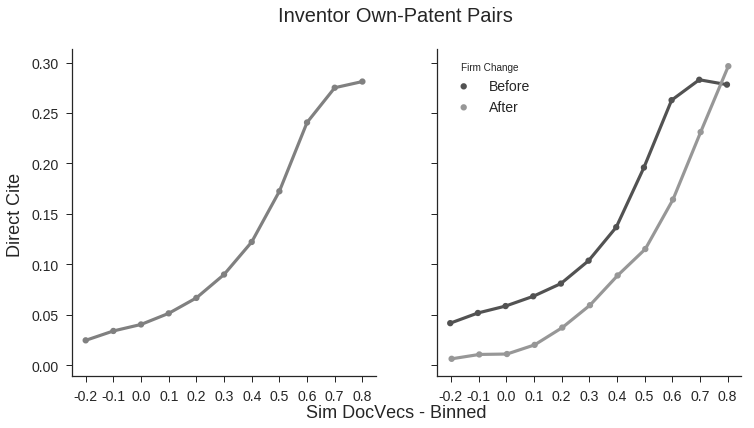

In [28]:
%matplotlib inline
f, axarr = plt.subplots(1, 2, sharex = False, sharey = True, figsize=(12,6))

x1 = "bin_sim_docvecs"
order1 = None
conf_int1 = None
y1 = "op_cites_tp"

# Overall - No MSA Match Hue
df = i2
g3 = p2(x = x1, y = y1, order = order1, data = df, ax = axarr[0], conf_int = conf_int1)

# Overall - MSA Match Hue
hue1 = "firm_change"
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = axarr[1])
g3.legend(loc='upper left', title = "Firm Change")

for ax in axarr.flatten():
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
#     plt.setp(ax.get_xticklabels(), visible=False)
#     plt.setp(ax.get_xticklabels()[::3], visible=True)

    
# Set common labels
font2 = matplotlib.font_manager.FontProperties(size=12)
f.text(0.5, 0.04, c_dict[x1], ha='center', va='center', fontproperties=font2).set_fontsize(18)
f.text(0.06, 0.5, c_dict[y1], ha='center', va='center', rotation='vertical', fontproperties=font2).set_fontsize(18)
f.suptitle("Inventor Own-Patent Pairs", size = 20)

plt.savefig(savepath+"1b-DV-SelfCites.png")